## Define Functions

In [25]:
#!/usr/bin/env python
# coding: utf-8

import geopandas as gpd
import pickle
import numpy as np
import glob
import os
import sys
import copy
import scipy.stats


from climada.util import coordinates as u_coords

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap

# =============================================================================
# Util functions
# =============================================================================

def load_dict(path_dict):
    # load any dict saved as pkl
    with open(path_dict, 'rb') as stats_dict:
         stats_dict = pickle.load(stats_dict)
    return stats_dict

def save_dict(dict_var, save_path):
    # save any dict as pkl
    with open(save_path, 'wb') as f:
        pickle.dump(dict_var, f) 
        
def load_gdf_dict(path_cntry_folder, haz_type, valid_events):
    # get all result dataframes filepaths
    if haz_type == 'TC':
        paths_result_files = [file for file in glob.glob(path_cntry_folder +'cascade_results*') 
                              if not 'DFO' in file]
        # select only result files that are still in valid hazard event selection
        paths_valid_resfiles = [path for path in paths_result_files 
                                if path.split('_')[-1] in valid_events]
        
    elif haz_type == 'FL':
        paths_result_files = glob.glob(path_cntry_folder + 'cascade_results_DFO*')
        # select only result files that are still in valid hazard event selection
        paths_valid_resfiles = [path for path in paths_result_files 
                                if 'DFO_'+ path.split('_')[-1] in valid_events]
    elif haz_type == 'RF':
        paths_result_files = [file for file in glob.glob(path_cntry_folder +'cascade_results*') 
                              if not 'DFO' in file]
        # select only result files that are still in valid hazard event selection
        paths_valid_resfiles = [path for path in paths_result_files 
                                if path.split('_')[-1] in valid_events]
    # move old files for good
    paths_invalid_resfiles = set(paths_result_files).difference(paths_valid_resfiles)
    for path in paths_invalid_resfiles:
        new_path = path_cntry_folder+f"old/cascade_results_{path.split('_')[-1]}"
        os.rename(path, new_path)
        
    # read in all result gdfs
    gdf_list= []
    name_list = []
    for file_path in paths_valid_resfiles:
        event_name = file_path.split('_')[-1] if haz_type in ['TC', 'RF'] else 'DFO_'+ file_path.split('_')[-1]
        name_list.append(event_name)
        gdf_list.append(gpd.read_feather(file_path)) 
    # make dict
    return dict(zip(name_list, gdf_list))

# =============================================================================
# Cascade State and Access State
# =============================================================================

def get_cascstate(gdf):
    """
    for infrastructure items. 0: functional state, 1: dysfunctional state, 
    2: cascaded dysfunctional state
    """
    casc_state = [0]* len(gdf)
    for i in range(len(gdf)):
        if ((gdf.func_tot.iloc[i]==0) & (gdf.func_internal.iloc[i]==0)):
            casc_state[i] = 1
        elif ((gdf.func_tot.iloc[i] ==0) & (gdf.func_internal.iloc[i] >0)):
            casc_state[i] = 2
    return casc_state                                   

def get_accessstates(gdf, node_gdf_orig):
    """
    1 - accessible, 0 - inaccessible from beginning on, -1 - disrupted due to 
    disaster. Careful - Changes gdf entries!
    """
    
    services = [colname for colname in gdf.columns if 'actual_supply_' in colname] 
    for service in services:
        serv_level = gdf[gdf.ci_type=='people'][service].values
        serv_level_orig = node_gdf_orig[node_gdf_orig.ci_type=='people'][service].values
        serv_level[(serv_level==0.) & (serv_level_orig==1.)]= -1.
        gdf.loc[gdf.ci_type=='people', service] = serv_level
    return gdf
 
def get_casc_and_access_states(gdf, gdf_nodes_orig, save_path=None):
    """
    re-calculate cascade-states for now, irrespective of whether it's been calculated.
    """
    gdf['casc_state'] = get_cascstate(gdf)
    gdf = get_accessstates(gdf, gdf_nodes_orig)
    if save_path is not None:
        gdf.to_feather(save_path)
    return gdf

# =============================================================================
# Adding up results
# =============================================================================

def sum_impacts(gdf_list, save_path=None):
    # sum up amounts of service failure events across all result gdfs
    services = [colname for colname in gdf_list[0].columns if 'actual_supply_' in colname]
    gdf_services = gdf_list[0][gdf_list[0].ci_type=='people'][['counts', 'geometry']]
    
    for service in services:
        service_counts = np.array(gdf_list[0][gdf_list[0].ci_type=='people'][service].values)
        for gdf in gdf_list[1:]:
            service_counts = np.vstack([service_counts, np.array(gdf[gdf.ci_type=='people'][service].values)])
        failures = np.ma.masked_greater_equal(service_counts, 0).sum(axis=0).filled(np.nan)
        inavails = np.ma.masked_not_equal(service_counts, 0).sum(axis=0).filled(np.nan)
        failures[~np.isnan(inavails)] = 0.
        failures[np.isnan(failures)] = 1.
        gdf_services[service] = failures
    
    impact_counts = np.round(np.array(gdf_list[0][gdf_list[0].ci_type=='people']['imp_dir'].values/
                             gdf_list[0][gdf_list[0].ci_type=='people']['counts'].values), 0)
    for gdf in gdf_list[1:]:
        impact_counts += np.round(np.array(gdf[gdf.ci_type=='people']['imp_dir'].values/gdf[gdf.ci_type=='people']['counts'].values), 0)
    gdf_services['imp_dir'] = impact_counts*-1 
    
    if save_path is not None:
        gdf_services.to_csv(save_path)
        
    return gdf_services


def sum_impacts_popweighted(gdf_summed, inv=False, save_path=None):
    """
    inv : bool
        if true, invert multiplication: disruption numbers are positive, with service are negative
        default: disruption numbers are negative, with service are positive
    """
    factor = -1 if inv else 1
    gdf_summed_popweighted = gdf_summed.apply(lambda row: row[2:]*factor*row.counts, axis=1)
    gdf_summed_popweighted[['counts', 'geometry']] = gdf_summed[['counts', 'geometry']]
    gdf_summed_popweighted['lat'] = gdf_summed_popweighted.geometry.y
    gdf_summed_popweighted['lon'] = gdf_summed_popweighted.geometry.x
    # path_cntry_folder+'summed_pop_impacts_inv.csv'
    if save_path is not None:
        gdf_summed_popweighted.to_csv(save_path)
    return gdf_summed_popweighted



def get_total_imps(event_stat_dict):
    event_keys = list(event_stat_dict.keys())
    total_imps = copy.deepcopy(event_stat_dict[event_keys[0]])
    for service, imp_val in total_imps.items():
        for event in event_keys[1:]:
            total_imps[service]+=event_stat_dict[event][service]
    return total_imps


# =============================================================================
# Meta-Analysis
# =============================================================================

def get_worst_events(event_stats_dict, frac=0.1, n_min=3, mode='service'):
    """
    mode = service or functionality
    """
    if n_min < np.ceil(len(event_stats_dict)*frac):
        n_min = int(np.ceil(len(event_stats_dict)*frac))
    event_sums = {}
    for event_name, serv_dict in event_stats_dict.items():
        if mode=='service':
            event_sums[event_name]=serv_dict['power']+serv_dict['healthcare']+serv_dict['education']+serv_dict['telecom']+serv_dict['mobility']
        elif mode=='functionality':
            event_sums[event_name]=serv_dict['power_line']+serv_dict['health']+serv_dict['education']+serv_dict['celltower']+serv_dict['road']+serv_dict['people']
    return sorted(zip(event_sums.values(),event_sums.keys()), reverse=True)[:n_min]

def compare_impact_rankings(disr_rate_dict, destruction_rate_dict):
    dir_imps = []
    serv_imps = []
    for event_name, serv_dict in disr_rate_dict.items():
        dir_imps.append(serv_dict['power']+serv_dict['healthcare']+serv_dict['education']+serv_dict['telecom']+serv_dict['mobility'])
        serv_imps.append(np.array(list(destruction_rate_dict[event_name].values())).sum())
    return scipy.stats.spearmanr(np.array(dir_imps), np.array(serv_imps)), [scipy.stats.rankdata(dir_imps),
                                                                            scipy.stats.rankdata(serv_imps)]


def get_diverging_events(event_stat_dict, ranklist, threshold=0.2):
    event_names = np.array(list(event_stat_dict.keys()))
    return event_names[np.abs(ranklist[0]-ranklist[1])>(threshold*len(event_names))]

# =============================================================================
# Conversions
# =============================================================================


def access_rate_conversion(base_stat_dict, gdf_nodes_orig, abs_num=False):
    """
    from number of ppl without access to number of poeple with access
    and access rates
    """
    total_pop = gdf_nodes_orig[gdf_nodes_orig.ci_type=='people'].counts.sum()
    access_rate_dict = {}
    factor = 1/total_pop if not abs_num else 1
    for key, value in base_stat_dict.items():
        access_rate_dict[key] = (total_pop-value)* factor
    return access_rate_dict


def disruption_rate_conversion(event_stats_dict, access_num_dict):
    """
    disruption rate: number of people who lost service access relative
    to those with initial service access
    """
    disruption_rate_dict = copy.deepcopy(event_stats_dict)
    for event_name, event_dict in disruption_rate_dict.items():
        for bs, event_imp in event_dict.items():
            disruption_rate_dict[event_name][bs] = event_imp/access_num_dict[bs]
    return disruption_rate_dict

def destruction_rate_conversion(dict_gdfs): 
    dicts_structimps = {}
    for event_name, gdf in dict_gdfs.items():
        dict_structimps = {}
        for ci_type, ci_name in zip(['power_line','health', 'education', 'celltower', 'road', 'people'],
                                    ['power lines', 'hospitals', 'schools', 'cell towers', 'roads', 'people']):
            dict_structimps[ci_type] = np.round(
                len(gdf[(gdf.ci_type==ci_type)&(gdf.func_internal==0)])/len(gdf[(gdf.ci_type==ci_type)])*100,1)
        dict_structimps['people'] = np.round(gdf[gdf.ci_type=='people'].imp_dir.sum()/gdf[gdf.ci_type=='people'].counts.sum()*100,
                                                 1)
        dicts_structimps[event_name] = dict_structimps
    return dicts_structimps

# =============================================================================
# Visualizing results
# =============================================================================

# Color definitions

class InfraColorMaps:
    def __init__(self):
        self.service_col_dict = {-1. : '#FF5733', 0. : 'grey', 1. : 'green'}
        self.service_col_map = ListedColormap(['#FF5733', 'grey', 'green'])
        self.servicecum_col_dict = {-9. : '#581845', -8. : '#581845',
                                -7. : '#581845', -6. : '#581845',  
                                -5. : '#581845', -4. : '#581845',
                                -3. : '#900C3F', -2. : '#C70039', 
                                -1. : '#FF5733', 0. : 'grey', 
                                 1. : 'green'}
        self.servicecum_col_map = ListedColormap(['#581845',  '#581845',
                                '#581845',  '#581845',  '#581845', '#581845',
                               '#900C3F', '#C70039',  '#FF5733', 'grey', 'green'])
        self.casc_col_dict = {0. : 'blue', 1. : 'magenta', 2. : 'yellow'}
        self.casc_col_map = ListedColormap(['blue','magenta','yellow'])

def _two_slope_norm(vmin=-10, vcenter=0, vmax=1):
    """
    Two Slope Norm example from
    https://matplotlib.org/stable/tutorials/colors/colormapnorms.html
    """
    #cols_access = plt.cm.Greens(np.linspace(0.75, 1, 25))
    cols_access = plt.cm.Greens(np.linspace(0.2, 0.3, 10))
    cols_inavail = plt.cm.Greys(np.linspace(0.2, 0.3, 11))
    cols_disrupt = plt.cm.magma(np.linspace(0, 0.75, 20))
    all_colors = np.vstack((cols_disrupt, cols_inavail, cols_access))
    segment_colmap = colors.LinearSegmentedColormap.from_list('service_states', all_colors)
    divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    return segment_colmap, divnorm      
        
#helper funcs

def service_dict():
    return {'power_line' : 'electricity',
           'celltower' : 'mobile communications',
           'health': 'healthcare facilities',
           'education' : 'educational facility',
           'road' : 'roads'}


def _get_extent(gdf):
    buffer_deg = 0.1
    sub_gdf = gdf[gdf.geometry.type == 'Point']
    return (min(sub_gdf.geometry.x)-buffer_deg, max(sub_gdf.geometry.x)+buffer_deg,
                     min(sub_gdf.geometry.y)-buffer_deg, max(sub_gdf.geometry.y)+buffer_deg)


def service_cumimpact_plot(gdf_cumimpacts, save_path=None):
    """
    per basic service, people cluster with and without access to that service
    """
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    services = [colname for colname in gdf_cumimpacts.columns if 'actual_supply_' in colname]
    services.append('imp_dir')
    #ci_types = set(gdf_cumimpacts.ci_type).difference({'people'})
    f, axes = plt.subplots(3, int(np.ceil(len(services)/3)), 
                           subplot_kw=dict(projection=ccrs.PlateCarree()),
                           figsize=(16,16))

    for service, ax in zip(services, axes.flatten()[:len(services)]):
        ax.set_extent(_get_extent(gdf_cumimpacts), ccrs.PlateCarree())
        ax.add_feature(border, facecolor='none', edgecolor='0.5')
        vmin = np.min(gdf_cumimpacts.iloc[:,2:].values)
        segment_map, divnorm = _two_slope_norm(vmin=vmin, vcenter=0, vmax=1)
        pcm = ax.scatter(gdf_cumimpacts.geometry.x, 
                         gdf_cumimpacts.geometry.y, 
                         c=gdf_cumimpacts[service], norm=divnorm,
                         cmap=segment_map, transform=ccrs.PlateCarree(),
                         s=0.05)
        cb = f.colorbar(pcm, shrink=0.6, ax=ax)
        tick_list = list(np.arange(vmin,0,5))
        tick_list.extend([0, 1])
        cb.set_ticks(tick_list)
        #plt.show()
        if service != 'imp_dir':
            ax.set_title(f'Disruptions in access to {service_dict()[service[14:-7]]}', 
                         weight='bold', fontsize=12) 
        else:
            ax.set_title('Direct impact pattern', weight='bold', fontsize=12) 
        
    if len(services)%2>0:
        f.delaxes(axes[2,-1])
    f.subplots_adjust(bottom=0.05, top=0.95)  
                            
    if save_path:
        plt.savefig(f'{save_path}'+f'service_disruptions_cum_{haz_type}.png', 
                    format='png', dpi=300,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)


def plot_rank_correlation(ranklist, spearmanr_res, event_names, save_path=None):
    f, ax = plt.subplots(1, 1, figsize=(8,8))
    ax.scatter( ranklist[1], ranklist[0])
    plt.title("rank correlation ")
    plt.xlabel("structural impact rank")
    plt.ylabel("service disruption impact rank")
    plt.axline((min(ranklist[0])-1, min(ranklist[0])-1), slope=1)
    plt.text(min(ranklist[0]), max(ranklist[0]), f'Spearman rank corr. coeff.: {np.round(spearmanr_res[0], 3)}')
    for i, txt in enumerate(event_names):
        ax.annotate(txt, (ranklist[1][i]-1, ranklist[0][i]+0.3))
    if save_path is not None:
        plt.savefig(f'{save_path}'+f'event_rankings_{haz_type}.png', 
                    format='png', dpi=72,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    
    plt.show()


def plot_relative_impacts_bars(imp_dict_relb, imp_dict_rela, save_path=None):
    """both in one
    relb - rel to base state availability
    rela - rel to direclty affected
    """ 
    f, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
    
    width = 0.8
    x = np.arange(5)
    
    ax1 = axes.flatten()[0]
    ax2 = axes.flatten()[1]
    
    relb_base = imp_dict_relb.pop('people')
    rela_base = imp_dict_rela.pop('people')
    relb_vals = np.round(np.array(list(imp_dict_relb.values())),4)
    rela_vals = np.round(np.array(list(imp_dict_rela.values())),4)
    
    labels = imp_dict_relb.keys()
    
    rects1 = ax1.bar(x, relb_vals, width, color='red', label='rel. to pop. with service access in base state')
    ax1.set_ylabel('Impact Factor')
    ax1.set_xticks(x, labels)
    ax1.plot([0.-width/2, 4+width/2], [relb_base, relb_base], "k--", linewidth=2)
    ax1.legend()
    ax1.bar_label(rects1, padding=3)
    
    rects2 = ax2.bar(x, rela_vals, width, color='blue', label='rel. to directly affected pop.')
    ax2.set_ylabel('Impact Factor')
    ax2.set_xticks(x, labels)
    ax2.plot([0.-width/2, 4+width/2], [rela_base, rela_base], "k--", linewidth=2)
    ax2.legend()
    ax2.bar_label(rects2, padding=3)
    year_range = '1980-2020' 
    if haz_type=='FL':
        year_range = '2002-2018'
    elif haz_type=='RF':
        year_range = '1971-2005'
    f.suptitle( f"Average relative service disruptions from {haz_type}s, {cntry}, {year_range}",  fontsize=16)
    f.tight_layout()
    if save_path is not None:
        plt.savefig(f'{save_path}'+f'rel_serv_impacts_bars_{haz_type}.png', 
                    format='png', dpi=72,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.show()

def plot_total_impacts_bars(imp_tot_dict, save_path=None):
    f, ax1 = plt.subplots(1, 1, figsize=(8, 5))
    
    width = 0.8
    y = np.arange(len(imp_tot_dict.keys())) 
    imp_vals = np.round(np.array(list(imp_tot_dict.values())),-3)
    
    labels = imp_tot_dict.keys()
    
    rects1 = ax1.barh(y, imp_vals, width, color='gray', label='total amount of people impacted')
    ax1.set_ylabel('Basic Service Type')
    ax1.set_yticks(y, labels)
    ax1.legend()
    ax1.bar_label(rects1, labels=["{:,}".format(int(num)) for num in imp_vals], padding=-5)
    ax1.ticklabel_format(useOffset=False, style='plain', axis='x')
    year_range = '1980-2020' 
    if haz_type=='FL':
        year_range = '2002-2018'
    elif haz_type=='RF':
        year_range = '1971-2005'
    f.suptitle( f"Cumulative service disruptions from {haz_type}s, {cntry}, {year_range}",  fontsize=16)
    f.tight_layout()
    if save_path is not None:
        plt.savefig(f'{save_path}'+f'tot_serv_impacts_bars_{haz_type}.png', 
                    format='png', dpi=72,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    plt.show()

def plot_worst_tc_tracks(worst_events, save_path=None):
    
    from climada.hazard import TCTracks
   
    
    tr_1 = TCTracks.from_ibtracs_netcdf(storm_id=worst_events[0])
    
    for event_id in worst_events[1:]:
        tr_1.append(TCTracks.from_ibtracs_netcdf(storm_id=event_id).data)

    ax = tr_1.plot();
    ax.get_legend()._loc = 2 # correct legend location
    ax.set_title('worst event tracks');
    ax.figure.tight_layout()
    if save_path is not None:
        ax.figure.savefig(f'{save_path}'+'worst_events_TC.png', 
                    format='png', dpi=150,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

def plot_worst_floods(worst_events, path_cntry_folder, save_path=None):
    
    from climada.hazard import Hazard
    
    path_haz = path_cntry_folder+f'flood_{iso3}.hdf5'
    hazards = Hazard('FL').from_hdf5(path_haz)
    hazards = hazards.select(event_names=worst_events)

    ax = hazards.plot_intensity(0)
    ax.set_title(f'Worst flood events {iso3}');
    ax.figure.tight_layout()
    if save_path is not None:
        ax.figure.savefig(f'{save_path}'+'worst_events_FL.png', 
                    format='png', dpi=150,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
        
def plot_worst_riverfloods(iso3, worst_events, path_flood, years=np.arange(1971,2006), save_path=None):
    
    from climada_petals.hazard.river_flood import RiverFlood
    
    gcm='gfdl-esm2m' 
    ghm='h08'
    rcp='historical_histsoc'
    
    dph_path = f'{path_flood}flddph_{gcm}_{ghm}_{rcp}_flopros.nc'
    frc_path = f'{path_flood}fldfrc_{gcm}_{ghm}_{rcp}_flopros.nc'
    rf = RiverFlood.from_nc(countries =[iso3], years=years, dph_path=dph_path, frc_path=frc_path)
    rf.centroids.set_geometry_points()
    
    rf = rf.select(event_names=worst_events)
    ax = rf.plot_intensity(0)
    ax.set_title(f'Worst flood events {iso3}');
    ax.figure.tight_layout()
    if save_path is not None:
        ax.figure.savefig(f'{save_path}'+'worst_events_RF.png', 
                    format='png', dpi=150,
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


## Execute

In [2]:

    # Variable definitions
    cntry = 'Haiti'# sys.argv[1]
    haz_type = 'TC'#sys.argv[2]
    iso3 = u_coords.country_to_iso(cntry)

    # paths
    PATH_ROOT = '/cluster/work/climate/evelynm/nw_outputs/'
    path_cntry_folder = PATH_ROOT+f'{iso3}/'
    path_save_plots = path_cntry_folder+'plots/'
    path_nodes = path_cntry_folder+'cis_nw_nodes'
    path_event_stats = path_cntry_folder+f'service_stats_{haz_type}_{iso3}.pkl'
    path_base_stats = path_cntry_folder+f'base_stats_{iso3}.pkl'
    if not os.path.exists(path_save_plots):
        os.makedirs(path_save_plots)
    if not os.path.exists(path_cntry_folder+'old/'):
        os.makedirs(path_cntry_folder+'old/')

In [3]:
    #load files 
    gdf_nodes_orig = gpd.read_feather(path_nodes)
    base_stat_dict = load_dict(path_base_stats)
    base_stat_dict['people'] = 0
    

In [4]:
event_stat_dict = load_dict(path_event_stats)
event_stat_dict

{'1980214N11330': {'power': 298777.04164886475,
  'healthcare': 1413968.2351913452,
  'education': 1448212.5495224,
  'telecom': 1263755.0517120361,
  'mobility': 1388038.2962417603,
  'people': 1593280.4524827106},
 '1987263N10309': {'power': 172946.1188430786,
  'healthcare': 459254.4228591919,
  'education': 665699.6781997681,
  'telecom': 465196.95053100586,
  'mobility': 373522.7753677368,
  'people': 574900.1006266206},
 '1988253N12306': {'power': 386976.31673431396,
  'healthcare': 710614.6814727783,
  'education': 1367663.5012207031,
  'telecom': 1209052.7122421265,
  'mobility': 348080.5707626343,
  'people': 603788.3764244217},
 '1998259N10335': {'power': 1163935.0397338867,
  'healthcare': 2290146.7183303833,
  'education': 3289307.5556106567,
  'telecom': 3262868.2679367065,
  'mobility': 726824.4216156006,
  'people': 1198934.1196458822},
 '2005296N16293': {'power': 9726.272048950195,
  'healthcare': 8355.907287597656,
  'education': 56753.376792907715,
  'telecom': 2741.6

In [6]:

    
    dict_gdfs = load_gdf_dict(path_cntry_folder, haz_type, valid_events=list(event_stat_dict.keys()))

In [9]:
dict_gdfs


{'1988253N12306':        ci_type  func_internal  func_tot     imp_dir  \
 285     people              1         1    0.000000   
 286     people              1         1    0.000000   
 287     people              1         1    0.000000   
 288     people              1         1    0.000000   
 289     people              1         1    0.000000   
 ...        ...            ...       ...         ...   
 127963    road              1         1    1.531967   
 127964    road              1         1    2.580911   
 127965    road              1         1  102.514064   
 127966    road              1         1   89.238417   
 127967    road              1         1   61.456749   
 
                                                  geometry  \
 285                            POINT (-72.86375 20.07042)   
 286                            POINT (-72.85542 20.07042)   
 287                            POINT (-72.84708 20.07042)   
 288                            POINT (-72.83875 20.07042)   

In [7]:
    # conversions
    access_rate_dict = access_rate_conversion(base_stat_dict, gdf_nodes_orig, abs_num=False)
    access_num_dict = access_rate_conversion(base_stat_dict, gdf_nodes_orig, abs_num=True)

In [7]:
disr_rate_dict = disruption_rate_conversion(event_stat_dict, access_num_dict)
save_dict(disr_rate_dict, path_cntry_folder+f'disruption_rates_{iso3}_{haz_type}.pkl')
destruction_rate_dict = destruction_rate_conversion(dict_gdfs)
save_dict(destruction_rate_dict, path_cntry_folder+f'destruction_rates_{iso3}_{haz_type}.pkl')

In [8]:
disr_rate_dict = load_dict(path_cntry_folder+f'disruption_rates_{iso3}_{haz_type}.pkl')
destruction_rate_dict = load_dict(path_cntry_folder+f'destruction_rates_{iso3}_{haz_type}.pkl')


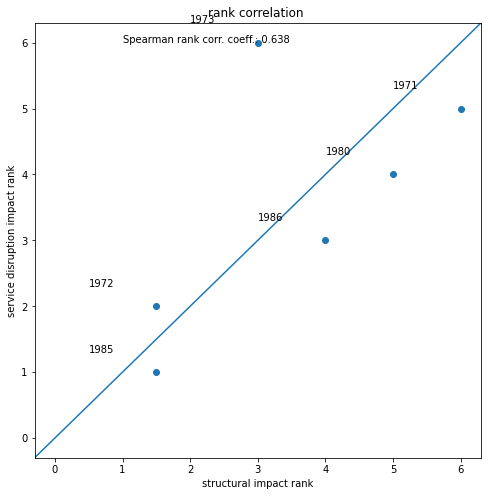

In [9]:

    # analysis
    spearmanr_res, ranklist = compare_impact_rankings(disr_rate_dict, destruction_rate_dict)
    plot_rank_correlation(ranklist, spearmanr_res, list(event_stat_dict.keys()), save_path=path_save_plots)

In [10]:
    # aggregating event results
    for key, gdf in dict_gdfs.items():
        save_path = path_cntry_folder + f'cascade_results_{key}'
        dict_gdfs[key] = get_casc_and_access_states(gdf, gdf_nodes_orig, save_path=save_path)

/scratch/tmp.7201908.evelynm/ipykernel_100663/1940259083.py:111: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf.to_feather(save_path)
/scratch/tmp.7201908.evelynm/ipykernel_100663/1940259083.py:111: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet re

In [11]:
gdf_summed = sum_impacts(
        [gdf for gdf in dict_gdfs.values()], 
        save_path=path_cntry_folder+f'summed_impacts_{haz_type}_{iso3}.csv')

In [12]:
    gdf_summed_popweighted = sum_impacts_popweighted(
        gdf_summed, 
        save_path=path_cntry_folder+f'summed_pop_impacts_{haz_type}_{iso3}.csv')

    total_imps = get_total_imps(event_stat_dict)
    save_dict(total_imps, path_cntry_folder+f'total_service_disruptions_{iso3}_{haz_type}.pkl')
    

In [9]:
total_imps= load_dict(path_cntry_folder+f'total_service_disruptions_{iso3}_{haz_type}.pkl')

In [10]:
import pandas as pd
gdf_summed_popweighted = pd.read_csv(path_cntry_folder+f'summed_pop_impacts_{haz_type}_{iso3}.csv')


In [16]:
# gdf_summed_popweighted = gpd.GeoDataFrame(gdf_summed_popweighted)
print(gdf_summed_popweighted.imp_dir < 0)
print(gdf_summed_popweighted.imp_dir)

0         True
1         True
2         True
3         True
4         True
         ...  
23296     True
23297     True
23298     True
23299     True
23300    False
Name: imp_dir, Length: 23301, dtype: bool
0       -111.170433
1       -114.766022
2       -113.712479
3       -114.387093
4       -122.083267
            ...    
23296   -516.014511
23297   -534.031723
23298   -588.179489
23299   -478.861038
23300     -0.000000
Name: imp_dir, Length: 23301, dtype: float64


In [17]:
gdf_summed_popweighted[['actual_supply_celltower_people',
       'actual_supply_education_people', 'actual_supply_health_people',
       'actual_supply_power_line_people', 'actual_supply_road_people', 'imp_dir']].sum()

actual_supply_celltower_people    -1.364169e+07
actual_supply_education_people    -1.627040e+07
actual_supply_health_people       -9.174851e+06
actual_supply_power_line_people   -6.849499e+06
actual_supply_road_people          3.480785e+06
imp_dir                           -6.074045e+06
dtype: float64

In [38]:
for service in ['actual_supply_celltower_people',
       'actual_supply_education_people', 'actual_supply_health_people',
       'actual_supply_power_line_people', 'actual_supply_road_people']:
    print(gdf_summed_popweighted[gdf_summed_popweighted[service]<0][service].sum()/(
    gdf_summed_popweighted[(gdf_summed_popweighted['imp_dir']<0) & (gdf_summed_popweighted[service]!=0)][service].sum()))

2.094665255515053
2.0176423869309468
2.1367906342776926
2.9502093380100995
1.7179411975670449


In [27]:
gdf_summed_popweighted[['actual_supply_celltower_people',
       'actual_supply_education_people', 'actual_supply_health_people',
       'actual_supply_power_line_people', 'actual_supply_road_people']].sum()/gdf_summed_popweighted['imp_dir'].sum()

actual_supply_celltower_people     2.245899
actual_supply_education_people     2.678676
actual_supply_health_people        1.510501
actual_supply_power_line_people    1.127667
actual_supply_road_people         -0.573059
dtype: float64

In [24]:
  
    # Impacts relative to directly affected
    total_imps_rela = {key : total_imps[key]/total_imps['people'] for key in total_imps.keys()}
    save_dict(total_imps_rela, path_cntry_folder+f'total_service_disruptions_rela_{iso3}_{haz_type}.pkl')
    # Impacts relative to base population with respective type of service access
    #total_imps_relb = {key : total_imps[key]/(access_num_dict[key]*len(disr_rate_dict))
    #                    for key in total_imps.keys()}
    
    total_imps_relb={}
    def service_dict2():
        return {'actual_supply_power_line_people' : 'electricity',
           'actual_supply_celltower_people' : 'mobile communications',
           'actual_supply_health_people': 'healthcare',
           'actual_supply_education_people' : 'education',
           'actual_supply_road_people' : 'mobility'}

    for variable, service in service_dict2().items():
        total_imps_relb[service] = gdf_summed_popweighted[gdf_summed_popweighted[variable]<0][variable].sum()/(
    gdf_summed_popweighted[(gdf_summed_popweighted['imp_dir']<0) & (gdf_summed_popweighted[variable]!=0)][variable].sum())
        total_imps_relb['people']=1
    save_dict(total_imps_relb, path_cntry_folder+f'total_service_disruptions_relb_{iso3}_{haz_type}.pkl')
   

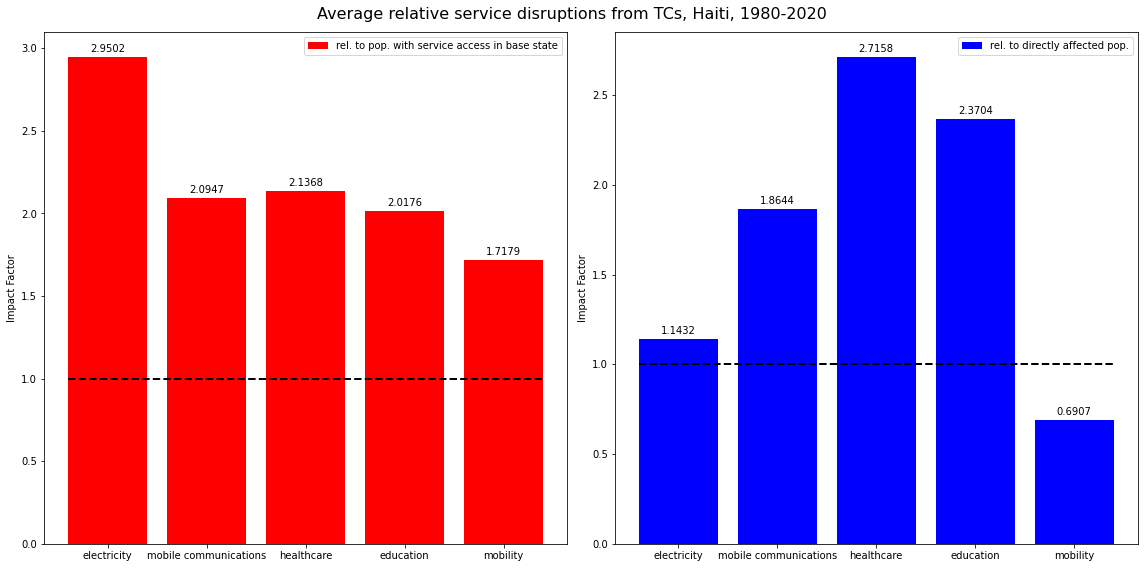

In [23]:
    plot_relative_impacts_bars(total_imps_relb, total_imps_rela, save_path=path_save_plots)

In [ ]:

    service_cumimpact_plot(gdf_summed, save_path=path_save_plots)
    
    worst_events_s = [worst[1] for worst in get_worst_events(disr_rate_dict, n_min=int(3), mode='service')]
    worst_events_f = [worst[1] for worst in get_worst_events(destruction_rate_dict, n_min=int(3), mode='functionality')]  

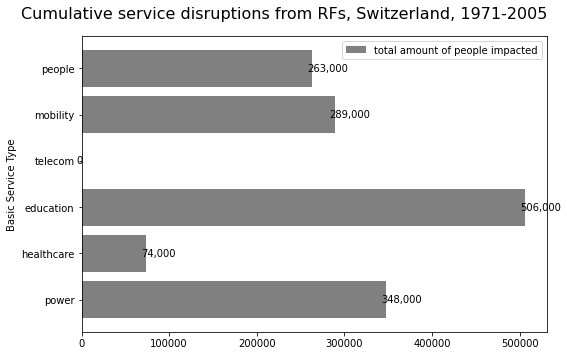

In [18]:
    #plot_worst_floods(worst_events_s, path_cntry_folder, save_path=path_save_plots)
    
    #plot_worst_event_tracks(worst_events_s, save_path=path_save_plots)
    
    div_events = get_diverging_events(event_stat_dict, ranklist)

    plot_total_impacts_bars(total_imps, save_path=path_save_plots)
    

2023-01-19 14:15:08,909 - climada.hazard.base - WARNING - The use of Hazard.set_raster is deprecated.Use Hazard.from_raster instead.


/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/rasterio/features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/rasterio/features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of

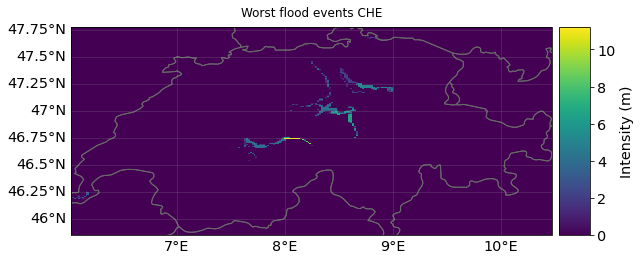

In [25]:
#plot_worst_floods(worst_events_s, path_cntry_folder, save_path=path_save_plots)

plot_worst_riverfloods(iso3, worst_events_s, path_flood=path_cntry_folder+f'{cntry.lower()}_isimip2b/',
                       years=np.arange(1971,2006), save_path=path_save_plots)


### Compute Results

In [100]:
    """ 
    # =============================================================================
    # Compute results
    # =============================================================================

    if __name__ == '__main__': 

        produces and saves the following plots:
            *
            *
            *
        produces and saves the following dataframes:
            *
            *
        produces and saves the following tex-file:


        # Variable definitions
        cntry = sys.argv[1]
        haz_type = sys.argv[2]
        iso3 = u_coords.country_to_iso(cntry)
    """
    # paths
    PATH_ROOT = '/cluster/work/climate/evelynm/nw_outputs/'
    path_cntry_folder = PATH_ROOT+f'{iso3}/'
    path_save_plots = path_cntry_folder+'plots/'
    path_nodes = path_cntry_folder+'cis_nw_nodes'
    path_event_stats = path_cntry_folder+f'service_stats_{haz_type}_{iso3}.pkl'
    path_base_stats = path_cntry_folder+f'base_stats_{iso3}.pkl'
    if not os.path.exists(path_save_plots):
        os.makedirs(path_save_plots)
    if not os.path.exists(path_cntry_folder+'old/'):
        os.makedirs(path_cntry_folder+'old/')

    #load files 
    gdf_nodes_orig = gpd.read_feather(path_nodes)
    base_stat_dict = load_dict(path_base_stats)
    base_stat_dict['people'] = 0
    event_stat_dict = load_dict(path_event_stats)
    dict_gdfs = load_gdf_dict(path_cntry_folder, haz_type, valid_events=list(event_stat_dict.keys()))
    
    # conversions
    access_rate_dict = access_rate_conversion(base_stat_dict, gdf_nodes_orig, abs_num=False)
    access_num_dict = access_rate_conversion(base_stat_dict, gdf_nodes_orig, abs_num=True)
    disr_rate_dict = disruption_rate_conversion(event_stat_dict, access_num_dict)
    save_dict(disr_rate_dict, path_cntry_folder+f'disruption_rates_{iso3}_{haz_type}.pkl')
    destruction_rate_dict = destruction_rate_conversion(dict_gdfs)
    save_dict(destruction_rate_dict, path_cntry_folder+f'destruction_rates_{iso3}_{haz_type}.pkl')

    

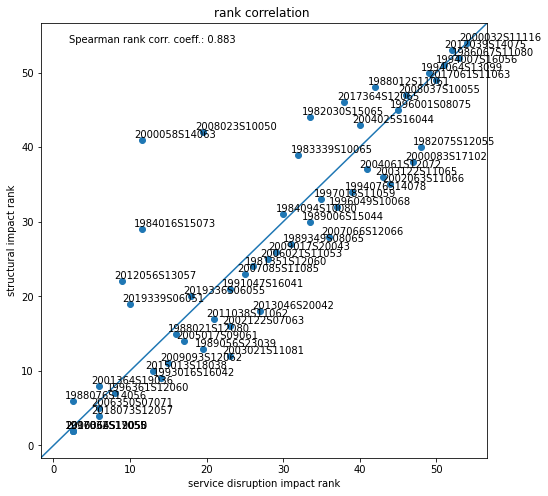

/scratch/tmp.6257432.evelynm/ipykernel_129697/2914348022.py:102: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf.to_feather(save_path)
/scratch/tmp.6257432.evelynm/ipykernel_129697/2914348022.py:102: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet re

/scratch/tmp.6257432.evelynm/ipykernel_129697/2914348022.py:102: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf.to_feather(save_path)
/scratch/tmp.6257432.evelynm/ipykernel_129697/2914348022.py:102: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet re

/scratch/tmp.6257432.evelynm/ipykernel_129697/2914348022.py:102: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf.to_feather(save_path)
/scratch/tmp.6257432.evelynm/ipykernel_129697/2914348022.py:102: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet re

In [ ]:
    # analysis
    spearmanr_res, ranklist = compare_impact_rankings(disr_rate_dict, destruction_rate_dict)
    plot_rank_correlation(ranklist, spearmanr_res, list(event_stat_dict.keys()), save_path=path_save_plots)

    # aggregating event results
    for key, gdf in dict_gdfs.items():
        save_path = path_cntry_folder + f'cascade_results_{key}'
        
        if ((os.stat(save_path).st_mtime > os.stat(path_nodes).st_mtime) & 
            ('casc_state' in gdf.columns)):
            print('Cascade and access analysis was already performed. Aborting')
            dict_gdfs[key] =  gdf
        else:
            dict_gdfs[key] = get_casc_and_access_states(gdf, gdf_nodes_orig, save_path=save_path)

    gdf_summed = sum_impacts(
        [gdf for gdf in dict_gdfs.values()], 
        save_path=path_cntry_folder+f'summed_impacts_{haz_type}_{iso3}.csv')

    gdf_summed_popweighted = sum_impacts_popweighted(
        gdf_summed, 
        save_path=path_cntry_folder+f'summed_pop_impacts_{haz_type}_{iso3}.csv')

    total_imps = get_total_imps(event_stat_dict)
    save_dict(total_imps, path_cntry_folder+f'total_service_disruptions_{iso3}_{haz_type}.pkl')
    
    # Impacts relative to directly affected
    total_imps_rela = {key : total_imps[key]/total_imps['people'] for key in total_imps.keys()}

    # Impacts relative to base population with respective type of service access
    total_imps_relb = {key : total_imps[key]/(access_num_dict[key]*len(disr_rate_dict))
                        for key in total_imps.keys()}

    plot_relative_impacts_bars(total_imps_relb, total_imps_rela, save_path=path_save_plots)

    service_cumimpact_plot(gdf_summed, save_path=path_save_plots)
    
    worst_events_s = [worst[1] for worst in get_worst_events(disr_rate_dict, n_min=int(3), mode='service')]
    worst_events_f = [worst[1] for worst in get_worst_events(destruction_rate_dict, n_min=int(3), mode='functionality')] 
    if haz_type=='TC':
        plot_worst_tc_tracks(worst_events_s, save_path=path_save_plots)
    elif haz_type=='FL':
        plot_worst_floods(worst_events_s, path_cntry_folder, save_path=path_save_plots)
    
    div_events = get_diverging_events(event_stat_dict, ranklist)

    plot_total_impacts_bars(total_imps, save_path=path_save_plots)
    

## Make all-in-one pdf

In [26]:
    # =============================================================================
    # Create a summary-pdf document with most important outputs
    # =============================================================================
    
    # heavily uses pylatex package 
    
    from pylatex import Document, Section, Subsection, Tabular, Figure, MiniPage,LargeText, LineBreak
    from pylatex.utils import bold
    import os
    
    # define necessary save and lookup paths
    
    path_root = f'countries/{iso3}/' 
    #change this according to where it is called from - now expects .tex file & .png files in same folder countries/iso3/ 
    path_imp_cum_plot = path_root+f'service_disruptions_cum_{haz_type}.png'
    path_imp_tot_plot = path_root+f'tot_serv_impacts_bars_{haz_type}.png'
    path_rankstats = path_root+f'event_rankings_{haz_type}.png'
    path_cum_relimpacts = path_root+f'rel_serv_impacts_bars_{haz_type}.png'
    worst_event_header_s = ['Event Name']
    worst_event_header_s.extend(list(base_stat_dict.keys()))
    worst_event_header_f = ['Event Name']
    worst_event_header_f.extend(list(list(destruction_rate_dict.values())[0].keys()))
    path_worst_event_plot = path_root+f'worst_events_{haz_type}.png'
    
    year_range = '1980-2020' 
    if haz_type=='FL':
        year_range = '2002-2018'
    elif haz_type=='RF':
        year_range = '1971-2005'
    
    geometry_options = {"tmargin": "2cm", "lmargin": "2cm", "rmargin": "2cm"}
    doc = Document(geometry_options=geometry_options)
    
    # Add Heading
    with doc.create(MiniPage(align='c')):
        doc.append(LargeText(bold(f"Summary Output for {haz_type}s, {cntry}, {year_range}")))
        doc.append(LineBreak())
            
    with doc.create(Section('Base case: Access rates statistics')):
        with doc.create(Tabular('llllll')) as table:
            table.add_hline()
            table.add_row(list(base_stat_dict.keys()))
            table.add_hline()
            table.add_empty_row()
            table.add_row(np.round(np.array(list(access_rate_dict.values()))*100,1))
        doc.append(LineBreak())
        doc.append('Access rates to respective services (%)')

    with doc.create(Section('Average service disruption impacts')):
        with doc.create(Figure(position='h!')) as imp_pic:
            imp_pic.add_image(path_cum_relimpacts, width='350px')
            imp_pic.add_caption(f'Relative service disruptions from {haz_type} {year_range}, {cntry}')

    with doc.create(Section('Cumulative service disruption impacts')): 
        doc.append(f'Number of {haz_type} events: {len(disr_rate_dict)}')
        
        with doc.create(Figure(position='h!')) as imp_pic:
            imp_pic.add_image(path_imp_tot_plot, width='250px')
            imp_pic.add_caption(f'Service disruptions from {haz_type} {year_range}, {cntry}')
            
        with doc.create(Figure(position='h!')) as imp_pic:
            imp_pic.add_image(path_imp_cum_plot, width='550px')
            imp_pic.add_caption(f'Spatial maps of service disruptions from {haz_type} {year_range}, {cntry}')
            
    with doc.create(Tabular('llllll')) as table:
            table.add_empty_row()
            table.add_empty_row()
            table.add_empty_row()
            table.add_empty_row()
        
    
    with doc.create(Section('Worst events overview')):
        with doc.create(Subsection('Worst event stats: Service Disruptions')):
            with doc.create(Tabular('lllllll')) as table:
                    table.add_hline()
                    table.add_row(worst_event_header_s)
                    table.add_hline()
                    table.add_empty_row()
                    for worst_event in worst_events_s:
                        table.add_row(list(np.append((worst_event), 
                                                     np.round(np.array(list(disr_rate_dict[worst_event].values()))*100,
                                                              1))))
                    table.add_empty_row()

            doc.append(LineBreak())
            doc.append('Worst events with respect to service access disruptions (%, relative to base state)')
        
        with doc.create(Subsection('Worst event stats: Direct Damages')):
            with doc.create(Tabular('lrrrrrr')) as table:
                    table.add_hline()
                    table.add_row(worst_event_header_f)
                    table.add_hline()
                    table.add_empty_row()
                    for worst_event in worst_events_f:
                        table.add_row(list(np.append((worst_event), 
                                                     np.round(np.array(list(destruction_rate_dict[worst_event].values())),
                                                              3))))
                    table.add_empty_row()
                    
            doc.append(LineBreak())
            doc.append('Worst events with respect to direct (structural) damages. In % relative to total units.')

            with doc.create(Figure(position='h!')) as imp_pic:
                imp_pic.add_image(path_worst_event_plot, width='350px')
                imp_pic.add_caption(f'Worst {haz_type} events, {cntry}')


            with doc.create(Subsection('Event ranks comparison')):
                with doc.create(Figure(position='htbp')) as imp_pic:
                    imp_pic.add_image(path_rankstats, width='350px')
                    imp_pic.add_caption('Comparison of event severeness ranks between direct impact metrics and service disruption metrics')
                doc.append('Most diverging events in ranking (> 20% rank difference):')
                doc.append(LineBreak())
                for event in list(div_events):
                    doc.append(event)
                    doc.append(LineBreak())
                

    doc.generate_tex(filepath=path_cntry_folder+f'summary_pages_{haz_type}_{iso3}')
